# 2D Nuclear Segmentation with Multiple Semantic Heads

In [1]:
import os
import errno

import numpy as np

import deepcell
from deepcell.utils.data_utils import get_data

X.shape: (325, 256, 256, 3)
y.shape: (325, 256, 256, 1)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]


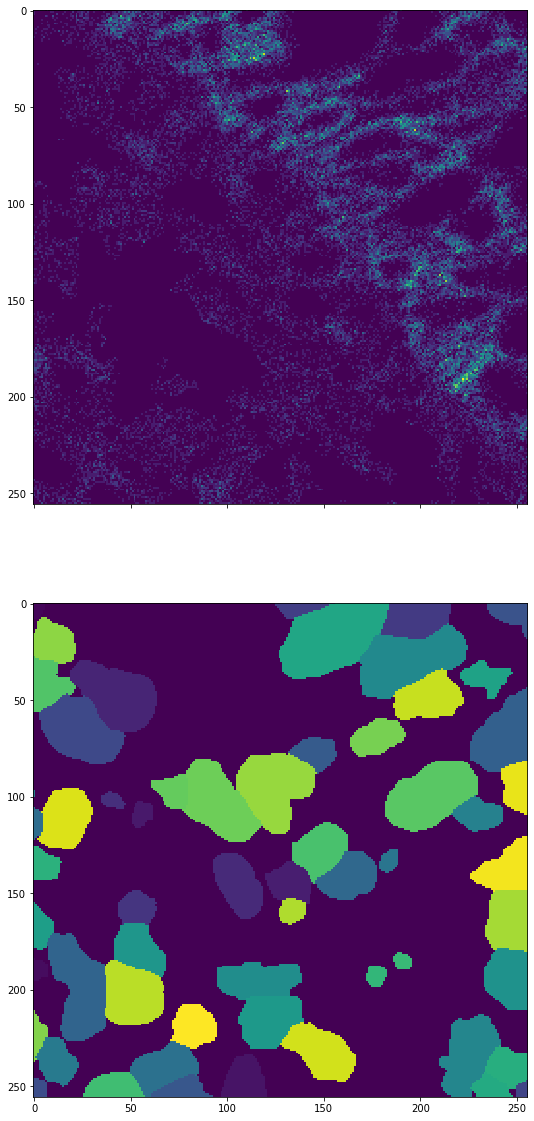

In [37]:
from deepcell.utils.data_utils import get_data, reshape_matrix
from skimage import morphology

from tensorflow.python.keras.utils.data_utils import get_file
from skimage.segmentation import relabel_sequential

DATA_DIR = "/data/npz_data/"
DATA_FILE = "/data/npz_data/lab_combined_train_256x256.npz"
test_size = 0.05
seed=0

train_dict, test_dict = get_data(DATA_FILE, test_size=test_size, seed=seed)
X_train, y_train = train_dict['X'], train_dict['y']
X_test, y_test = test_dict['X'], test_dict['y']
   
    
for i in range(y_train.shape[0]):
        y_train[i], _, _ = relabel_sequential(y_train[i])
        
for i in range(y_test.shape[0]):
        y_test[i], _, _ = relabel_sequential(y_test[i])
        
               
print('X.shape: {}\ny.shape: {}'.format(X_train.shape, y_train.shape))
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(20, 20), sharex=True, sharey=True)
axes[0].imshow(X_train[0,:,:,1])
axes[1].imshow(y_train[0,:,:,0])
print(np.unique(y_train[0]))
# axes.set_title('Source Image')


In [38]:
# Set up other required filepaths

# If the data file is in a subdirectory, mirror it in MODEL_DIR and LOG_DIR
PREFIX = os.path.relpath(os.path.dirname(DATA_FILE), DATA_DIR)

ROOT_DIR = '/data'  # TODO: Change this! Usually a mounted volume
MODEL_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'models', PREFIX, '20190912_FPN'))
LOG_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'logs', PREFIX))

# create directories if they do not exist
for d in (MODEL_DIR, LOG_DIR):
    try:
        os.makedirs(d)
    except OSError as exc:  # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise

### Set up training parameters

In [36]:
from tensorflow.keras.optimizers import SGD, Adam
from deepcell.utils.train_utils import rate_scheduler

# Supported backbones:
# vgg16, vgg19
# densenet121, densenet169, densenet201
# mobilenet, mobilenetv2
# nasnet_large, nasnet_mobile
# resnet50
backbone = 'resnet50'

model_name = '{}_retinanet_50x_nuc'.format(backbone)

n_epoch = 100  # Number of training epochs
test_size = .10  # % of data saved as test
lr = 1e-5

optimizer = Adam(lr=lr, clipnorm=0.001)

lr_sched = rate_scheduler(lr=lr, decay=0.99)

batch_size = 4

num_classes = 1  # "object" is the only class

## Create the RetinaNet Model

In [15]:
from deepcell.utils.retinanet_anchor_utils import generate_anchor_params
from tensorflow.python.keras import backend as K

backbone_levels = ['C1', 'C2', 'C3', 'C4', 'C5']
pyramid_levels = ['P2', 'P3', 'P4', 'P5']
anchor_size_dict = {'P2':16, 'P3':32, 'P4':64, 'P5':128}

anchor_params = generate_anchor_params(pyramid_levels, anchor_size_dict)

In [16]:
from deepcell import model_zoo

# training model is `retinanet` while prediction model is `retinanet_bbox`
model = model_zoo.RetinaMask(
    backbone=backbone,
    norm_method=None,
    use_imagenet=True,
    panoptic=True,
    num_semantic_heads=2,
    num_semantic_classes = [4, 3],
    input_shape=X_train.shape[1:],
    num_classes=num_classes,
    backbone_levels=backbone_levels,
    pyramid_levels=pyramid_levels,
    anchor_params=anchor_params)

# model.summary()
# print(model.layers[0].output_shape)

W1204 06:41:40.778807 140325674190656 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


94773248/94765736 [==============================] - 3s 0us/step


W1204 06:42:57.679305 140325674190656 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/initializers.py:143: calling RandomNormal.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1204 06:42:57.813535 140325674190656 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/deepcell/layers/upsample.py:149: The name tf.image.resize_images is deprecated. Please use tf.image.resize instead.

W1204 06:43:06.811502 140325674190656 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/autograph/impl/api.py:255: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W

In [ ]:
from deepcell.training import train_model_retinanet
model = train_model_retinanet(
    model=model,
    backbone=backbone,
    dataset=DATA_FILE,  # full path to npz file
    model_name=model_name,
    include_masks=True,
    panoptic=True,
    panoptic_weight=0.1,
    transforms=['watershed', 'pixelwise'],
    transforms_kwargs={'pixelwise': {'separate_edge_classes': False}, 'watershed': {'erosion_width': 2}},
    anchor_params=anchor_params,
    pyramid_levels=pyramid_levels,
    sigma=3.0,
    alpha=0.25,
    gamma=2.0,
    weighted_average=True,
    score_threshold=0.01,
    iou_threshold=0.5,
    max_detections=100,
    test_size=test_size,
    optimizer=optimizer,
    batch_size=batch_size,
    n_epoch=n_epoch,
    log_dir=None,
    model_dir=MODEL_DIR,
    lr_sched=lr_sched,
    compute_map=False,
    rotation_range=180,
    flip=True,
    shear=False,
    zoom_range=(0.8, 1.2))

W1204 06:44:10.311543 140325674190656 training_utils.py:1101] Output filtered_detections missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to filtered_detections.
W1204 06:44:10.312601 140325674190656 training_utils.py:1101] Output filtered_detections_1 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to filtered_detections_1.
W1204 06:44:10.313471 140325674190656 training_utils.py:1101] Output filtered_detections_2 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to filtered_detections_2.
W1204 06:44:10.314141 140325674190656 training_utils.py:1101] Output mask_submodel missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to mask_submodel.


X_train shape: (308, 256, 256, 3)
y_train shape: (308, 256, 256, 1)
X_test shape: (35, 256, 256, 3)
y_test shape: (35, 256, 256, 1)
Output Shape: (None, None, None, 3)
Number of Classes: 3
Training on 1 GPUs


W1204 06:50:11.414229 140325674190656 retinanet.py:295] Removing 43 of 308 images with fewer than 3 objects.
W1204 06:50:36.690145 140325674190656 retinanet.py:295] Removing 6 of 35 images with fewer than 3 objects.


Epoch 1/100


/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


65/66 [============================>.] - ETA: 1s - loss: 4.1909 - regression_loss: 2.8237 - classification_loss: 1.0165 - masks_loss: 0.1309 - semantic_0_loss: 0.1294 - semantic_1_loss: 0.0903
Epoch 00001: val_loss improved from inf to 4.30430, saving model to /data/models/20190912_FPN/resnet50_retinanet_50x_nuc.h5
1658 instances of class 0 with average precision: 0.0185
mAP: 0.0185
66/66 [==============================] - 246s 4s/step - loss: 4.1894 - regression_loss: 2.8215 - classification_loss: 1.0095 - masks_loss: 0.1391 - semantic_0_loss: 0.1292 - semantic_1_loss: 0.0901 - val_loss: 4.3043 - val_regression_loss: 2.6813 - val_classification_loss: 0.6725 - val_masks_loss: 0.6554 - val_semantic_0_loss: 0.1488 - val_semantic_1_loss: 0.1464
Epoch 2/100
59/66 [=========================>....] - ETA: 5s - loss: 3.9013 - regression_loss: 2.6761 - classification_loss: 0.4368 - masks_loss: 0.6197 - semantic_0_loss: 0.1056 - semantic_1_loss: 0.0631

In [51]:
# metrics
hist = np.load(os.path.join(MODEL_DIR, model_name + '.npz'), allow_pickle=True)
hist['loss_history'].tolist()['loss']

[4.188364171433723,
 3.8826017535052535,
 3.5447682594430856,
 3.109491881739591,
 2.851051092147827,
 2.71824833533773,
 2.632080302841362,
 2.5546819396402642,
 2.4810784438560747,
 2.4418111477775137,
 2.3920088901373617,
 2.3109533622347076,
 2.311353215769333,
 2.2570680768097042,
 2.238531629701227,
 2.157776561650363,
 2.1599119559101676,
 2.1238446281330794,
 2.1168270933535673,
 2.074425329193758,
 2.0798091331204236,
 2.0240072820378447,
 2.024808176632585,
 2.0262451767921448,
 1.9836582462917003,
 1.9573796662417324,
 1.9546215654343597,
 1.9491212240124114,
 1.9314476305788213,
 1.8994658492332281,
 1.913330148566853,
 1.8836728256780984,
 1.87384094589058,
 1.8691470814847397,
 1.8459821441621158,
 1.835885342967008,
 1.8340270278989808,
 1.8407930469147546,
 1.8143949996341358,
 1.8186620003418905,
 1.8082296792850938,
 1.8013539223959951,
 1.774670442858875,
 1.7746537768521071,
 1.7891828876802292,
 1.7778754216044341,
 1.752525101676298,
 1.7571039702243731,
 1.740224

In [18]:
# Set up the prediction model
from deepcell import model_zoo

# Set up the prediction model
prediction_model = model_zoo.RetinaMask(
    backbone=backbone,
    use_imagenet=False,
    panoptic=True,
    num_semantic_heads=2,
    num_semantic_classes=[4, 3],
    input_shape=(None, None, X_train.shape[-1]),  # general input size
    num_classes=num_classes,
    backbone_levels=backbone_levels,
    pyramid_levels=pyramid_levels,
    anchor_params=anchor_params)

prediction_model.load_weights(os.path.join(MODEL_DIR, model_name + '.h5'))

In [19]:
from skimage.transform import resize 
from skimage.measure import label
from skimage.morphology import watershed, remove_small_objects
from skimage.feature import peak_local_max
from scipy.ndimage.morphology import distance_transform_edt
from skimage.segmentation import random_walker, relabel_sequential
from tensorflow.keras import backend as K


def compute_iou(a, b):
    """Computes the IoU overlap of boxes in a and b.
    Args:
        a: (N, H, W) ndarray of float
        b: (K, H, W) ndarray of float
    Returns
        overlaps: (N, K) ndarray of overlap between boxes and query_boxes
    """
    intersection = np.zeros((a.shape[0], b.shape[0]))
    union = np.zeros((a.shape[0], b.shape[0]))
    for index, mask in enumerate(a):
        intersection[index, :] = np.sum(np.count_nonzero(np.logical_and(b, mask), axis=1), axis=1)
        union[index, :] = np.sum(np.count_nonzero(b + mask, axis=1), axis=1)

    return intersection / union


def retinanet_to_label_image(retinanet_outputs, score_threshold=0.5, multi_iou_threshold=0.25,
                             binarize_threshold=0.5, watershed_threshold=0.5, small_objects_threshold=100):
    boxes_batch = retinanet_outputs[-5]
    scores_batch = retinanet_outputs[-4]
    labels_batch = retinanet_outputs[-3]
    masks_batch = retinanet_outputs[-2]
    semantic_batch = retinanet_outputs[-1]
    
    # Create empty label matrix
    label_images = np.zeros((masks_batch.shape[0], semantic_batch.shape[1], semantic_batch.shape[2]))
    
    # Iterate over batches
    for i in range(boxes_batch.shape[0]):
        boxes = boxes_batch[i]
        scores = scores_batch[i]
        labels = labels_batch[i]
        masks = masks_batch[i]
        semantic = semantic_batch[i]

        # Get good detections
        selection = np.nonzero(scores_batch[i] > score_threshold)[0]
        boxes = boxes[selection]
        scores = scores[selection]
        labels = labels[selection]
        masks = masks[selection, ..., -1]
        
        # Compute overlap of masks with each other
        mask_shape = (masks.shape[0], semantic.shape[0], semantic.shape[1])
        mask_image = np.zeros(mask_shape, dtype=K.floatx())

        for j in range(masks.shape[0]):
            mask = masks[j]
            box = boxes[j].astype(int)
            try:
                mask = resize(mask, (box[3] - box[1], box[2] - box[0]))
            except:
                print(box)
            mask = (mask > binarize_threshold).astype(K.floatx())
            mask_image[j, box[1]:box[3], box[0]:box[2]] = mask
        
        ious = compute_iou(mask_image, mask_image)
        
        # Identify all the masks with no overlaps and 
        # add to the label matrix
        summed_ious = np.sum(ious, axis=-1)
        no_overlaps = np.where(summed_ious == 1)
        
        masks_no_overlaps = mask_image[no_overlaps]
        range_no_overlaps = np.arange(1, masks_no_overlaps.shape[0] + 1)
        masks_no_overlaps *= np.expand_dims(np.expand_dims(range_no_overlaps, axis=-1), axis=-1)
        
        masks_concat = masks_no_overlaps
        
        # If a mask has a big iou with two other masks, remove it
        overlaps = np.where(summed_ious > 1)
        bad_mask = np.sum(ious > multi_iou_threshold, axis=0)
        good_overlaps = np.logical_and(summed_ious > 1, bad_mask < 3)
        good_overlaps = np.where(good_overlaps == 1)
        
        # Identify all the ambiguous pixels and resolve
        # by performing marker based watershed using unambiguous
        # pixels as the markers
        masks_overlaps = mask_image[good_overlaps]
        range_overlaps = np.arange(1, masks_overlaps.shape[0] + 1)
        masks_overlaps_label = masks_overlaps * np.expand_dims(
            np.expand_dims(range_overlaps, axis=-1), axis=-1)
        
        masks_overlaps_sum = np.sum(masks_overlaps, axis=0)
        ambiguous_pixels = np.where(masks_overlaps_sum > 1)
        markers = np.sum(masks_overlaps_label, axis=0)
        
        if np.sum(markers.flatten()) > 0:
            markers[markers == 0] = -1
            markers[ambiguous_pixels] = 0

            foreground = masks_overlaps_sum > 0
            segments = random_walker(foreground, markers)

            masks_overlaps = np.zeros((np.amax(segments).astype(int), 
                                       masks_overlaps.shape[1], masks_overlaps.shape[2]))

            for j in range(1, masks_overlaps.shape[0] + 1):
                masks_overlaps[j - 1] = segments == j

            range_overlaps = np.arange(masks_no_overlaps.shape[0] + 1, 
                                       masks_no_overlaps.shape[0] + masks_overlaps.shape[0] + 1)
            masks_overlaps *= np.expand_dims(np.expand_dims(range_overlaps, axis=-1), axis=-1)
            masks_concat = np.concatenate([masks_concat, masks_overlaps], axis=0)
              
            
        # Find peaks in watershed that are not within any
        # box and perform watershed
        semantic_argmax = np.argmax(semantic, axis=-1) 
        semantic_argmax *= np.sum(masks_concat, axis=0) < 1
        foreground = semantic_argmax > 0

        inner_most = semantic[..., -1] * (np.sum(masks_concat, axis=0) < 1)
        local_maxi = inner_most > watershed_threshold
        
        if np.sum(local_maxi.flatten()) > 0:
            markers_semantic = label(local_maxi)
            distance = semantic_argmax
            segments_semantic = watershed(-distance, markers_semantic, mask=foreground)
            masks_semantic = np.zeros((np.amax(segments_semantic).astype(int), 
                                       semantic.shape[0], semantic.shape[1]))
            for j in range(1, masks_semantic.shape[0] + 1):
                masks_semantic[j-1] = segments_semantic == j
            
            range_semantic = np.arange(masks_no_overlaps.shape[0] + masks_overlaps.shape[0] + 1,
                                       masks_no_overlaps.shape[0] + masks_overlaps.shape[0] + masks_semantic.shape[0] + 1)

            masks_semantic *= np.expand_dims(np.expand_dims(range_semantic, axis=-1), axis=-1)
        
            masks_concat = np.concatenate([masks_concat, masks_semantic], axis=0)
        
        label_image = np.sum(masks_concat, axis=0).astype(int)
        
        # Remove small objects
        label_image = remove_small_objects(label_image, min_size=small_objects_threshold)
        
        # Relabel the label image
        label_image, _, _ = relabel_sequential(label_image)
        
        # Store in batched array
        label_images[i] = label_image
        
    return label_images

In [28]:
test_data = np.load('/data/npz_data/lab_combined_test.npz')
X_test_full = test_data['X']
y_test_full = test_data['y']

In [29]:
X_test = X_test_full[:1, 300:600, 300:600, :]
y_test = y_test_full[:1, 300:600, 300:600, :]

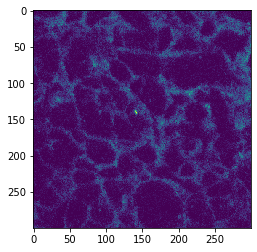

In [32]:
plt.imshow(X_test[0, :, :, 1])

Image Number: 0


W1204 16:52:39.051717 140325674190656 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


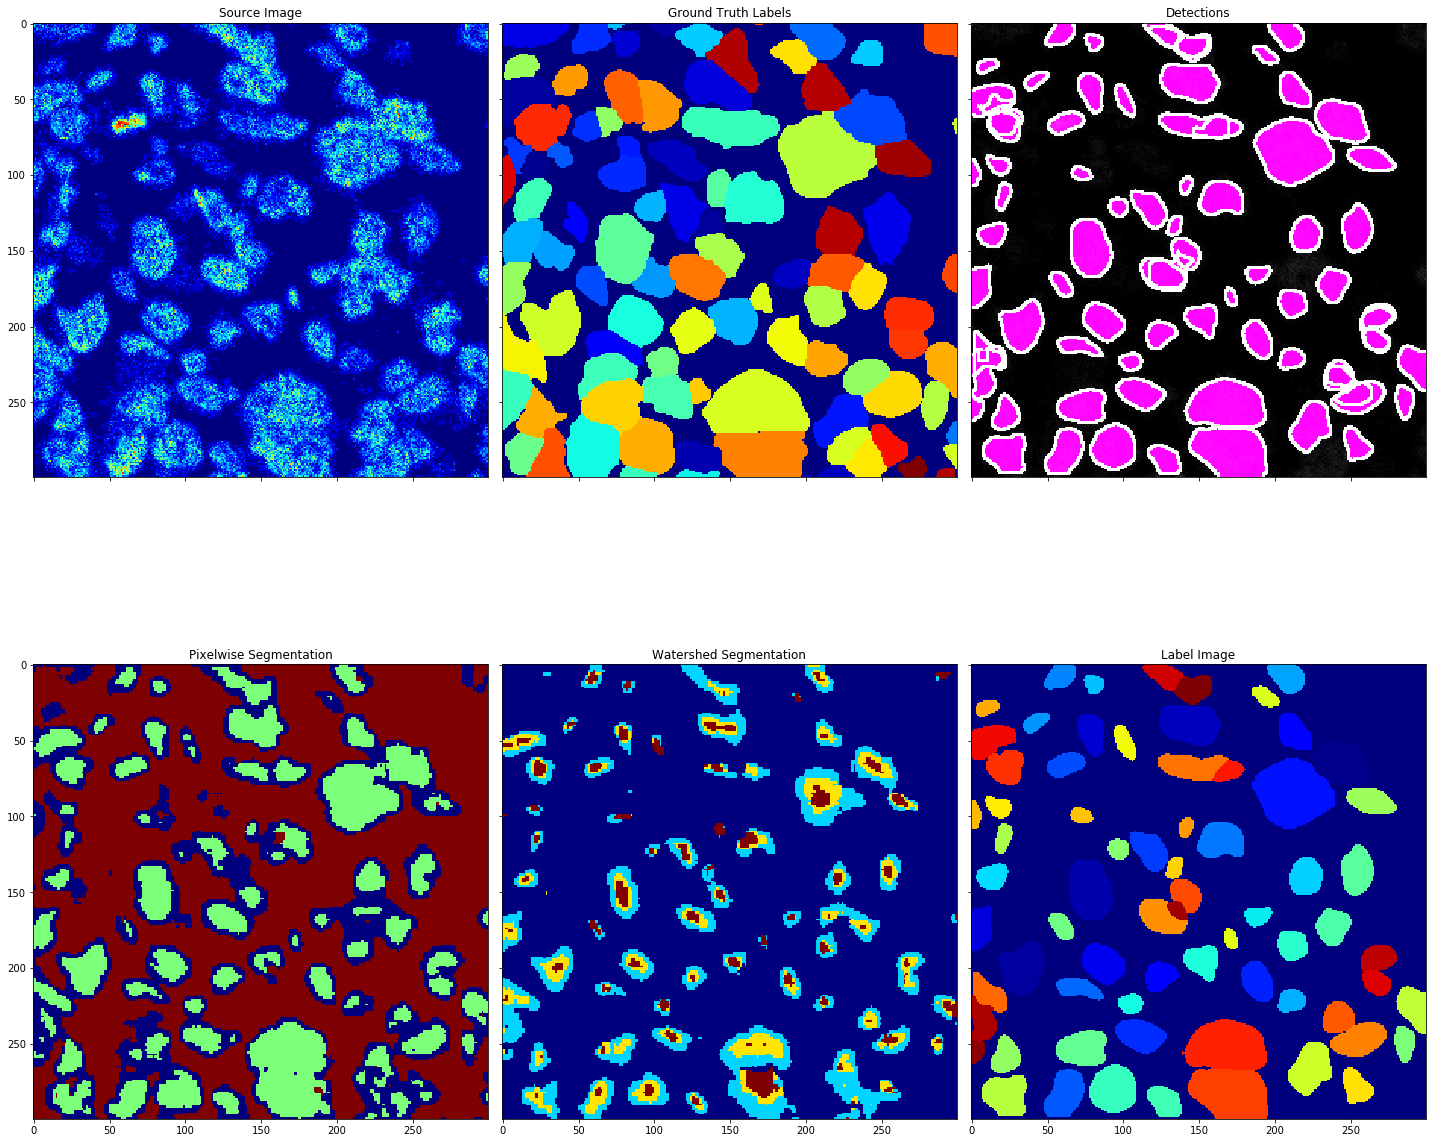

In [34]:
import matplotlib.pyplot as plt
import os
import time

import numpy as np

from skimage.transform import resize 
from skimage.measure import label
from skimage.exposure import equalize_hist, rescale_intensity

from deepcell.utils.plot_utils import draw_detections, draw_masks


index = np.random.randint(low=0, high=X_test.shape[0])
print('Image Number:', index)

image, mask = X_test[index:index + 1], y_test[index:index + 1]

results = prediction_model.predict(image)

image = 0.01 * np.tile(np.expand_dims(image[0, ..., 0], axis=-1), (1, 1, 3))
mask = np.squeeze(mask)

boxes  = results[-6]
scores = results[-5]
labels = results[-4]
masks  = results[-3]
semantic = [np.argmax(s[0], axis=-1) for s in results[-2:]]

label_image = retinanet_to_label_image(results[:-1])

# copy to draw on
draw = image.copy()

# draw the masks
draw_masks(draw, boxes[0], scores[0], masks[0], score_threshold=0.5)

display_image = image.copy()
display_image = rescale_intensity(display_image, out_range=(-1, 1))

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(20, 20), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(display_image[..., -1], cmap='jet')
ax[0].set_title('Source Image')

ax[1].imshow(mask, cmap='jet')
ax[1].set_title('Ground Truth Labels')

ax[2].imshow(draw, cmap='jet')
ax[2].set_title('Detections')

ax[3].imshow(semantic[1], cmap='jet')
ax[3].set_title('Pixelwise Segmentation')
            
ax[4].imshow(semantic[0], cmap='jet')
ax[4].set_title('Watershed Segmentation')

ax[5].imshow(label_image[0], cmap='jet')
ax[5].set_title('Label Image')

plt.tight_layout()
plt.show()

In [22]:
hist = np.load(MODEL_DIR + '/resnet50_retinanet_50x_nuc.npz')

TypeError: 'method' object is not iterable

In [17]:
from deepcell import metrics
m = metrics.Metrics('retina',seg=False)

y_true_lbl = y_test[:,:,:,0].astype('int')
y_pred_lbl = label_image[:,:,:]

m.calc_object_stats(y_true_lbl,y_pred_lbl)


____________Object-based statistics____________

Number of true cells:		 561
Number of predicted cells:	 181

Correct detections:  98	Recall: 17.468805704099821696217986755073070526123046875%
Incorrect detections: 83	Precision: 54.14364640883977841667729080654680728912353515625%

Gained detections: 75	Perc Error: 14.17769376181474427767170709557831287384033203125%
Missed detections: 446	Perc Error: 84.3100189035916827151595498435199260711669921875%
Merges: 8		Perc Error: 1.5122873345935727851241381358704529702663421630859375%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 9
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.371431714049035688329780668937019072473049163818359375 



In [43]:
new_tile = plt.imread('/data/Training_Freeze_1_Nuc_81_rf_512_dense_128_conv_epoch_27Point8.npy_label_mask_0.15_interior_threshold_2erosion.tiff')

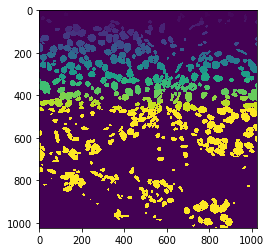

In [50]:
plt.imshow(new_tile[:, :, 1])

In [ ]:
from deepcell import metrics
m = metrics.Metrics('retina',seg=True)

y_true_lbl = y_test[:,:,:,0].astype('int')
#y_pred_lbl[0, :, :] = label_image[:,:,:]
y_pred_lbl = np.zeros((1, 1024, 1024), dtype='int16')
y_pred_lbl[0, :, :] = new_tile[:, :, 0]

m.calc_object_stats(y_true_lbl,y_pred_lbl)